# Signed distance functions (SDFs)

SDFs are functions $f: \mathbb{R}^3\to\mathbb{R}$
where $d=f(x)$ is the shortest signed distance from the point $x$ to a surface
$\mathcal{S} = \partial\mathcal{M}$ of a closed volume $\mathcal{M}\subset\mathbb{R}^3$ where
the sign indicates whether $x$ is inside or outside of $\mathcal{M}$. The surface $\mathcal S$ is thus represented _implicitly_
as the zero level-set of $f$:
$$
\mathcal{S} = \{x\in\mathbb{R}^3 | f(x)=0\}
$$

In [18]:
import jax
import jax.numpy as jnp
import jax.random as jrandom
from jax import vmap
import equinox as eqx

def sdf_sphere(x):
    return jnp.dot(x, x) - 1

## Sphere in two dimensions (circle)

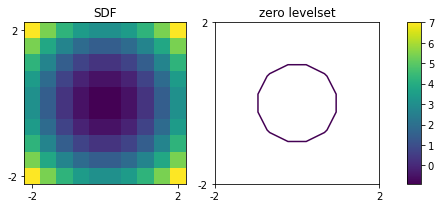

In [19]:
import functools as ft
import matplotlib.pyplot as plt
from IPython.display import clear_output
%matplotlib inline

@eqx.filter_jit
def discretize2d(sdf, xy_lims, ngrid):
    xs = jnp.meshgrid(jnp.linspace(*xy_lims, ngrid), 
                      jnp.linspace(*xy_lims, ngrid))
    xs = jnp.stack(xs, axis=-1) # (nx, ny, 2)
    ys = vmap(vmap(sdf))(xs)
    return xs, ys

def plot2d(sdf, xy_lims=(-2,2), ngrid=10):
    xs, ys = discretize2d(sdf, xy_lims, ngrid)
    # fig, axs = plt.subplots(ncols=2, figsize=(6,3))
    fig = plt.figure(figsize=(6.25,3))
    gs = plt.GridSpec(1,3, width_ratios=[3,3,0.25])
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])
    ax2 = plt.subplot(gs[2])
    c = ax0.imshow(ys, origin='lower')
    ax0.set_title("SDF")
    ax1.contour(ys, levels=[0.])
    ax1.set_title("zero levelset")
    for ax in [ax0, ax1]:
        ax.set_xticks([0,ngrid-1])
        ax.set_xticklabels(xy_lims)
        ax.set_yticks([0,ngrid-1])
        ax.set_yticklabels(xy_lims)
    plt.colorbar(c, cax=ax2)
    plt.tight_layout()

plot2d(sdf_sphere)

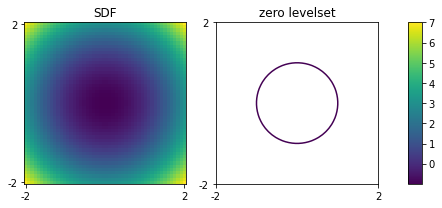

In [20]:
plot2d(sdf_sphere, ngrid=50)

## Sphere in three dimensions

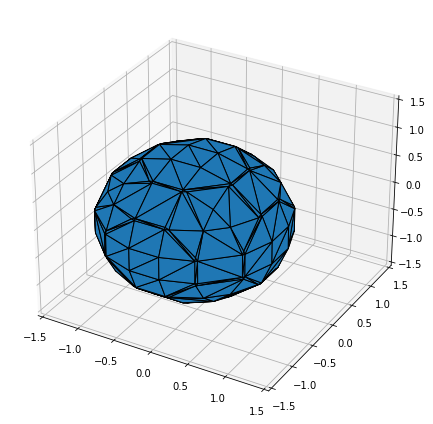

In [21]:
import numpy as np
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage import measure

@eqx.filter_jit
def discretize3d(sdf, xyz_lims, ngrid):
    xs = jnp.meshgrid(jnp.linspace(*xyz_lims, ngrid),
                      jnp.linspace(*xyz_lims, ngrid),
                      jnp.linspace(*xyz_lims, ngrid))
    xs = jnp.stack(xs, axis=-1) # (nx, ny, nz, 3)
    ys = vmap(vmap(vmap(sdf)))(xs)
    return xs, ys

def plot3d(sdf, xyz_lims=(-2,2), ngrid=10):
    xs, ys = discretize3d(sdf, xyz_lims, ngrid)
    verts, faces, normals, values = measure.marching_cubes(np.array(ys), 0)
    verts = (verts / 10) * 4 - 2

    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='3d')
    mesh = Poly3DCollection(verts[faces])
    mesh.set_edgecolor('k')
    ax.add_collection3d(mesh)
    ax.set_xlim(*xyz_lims)
    ax.set_ylim(*xyz_lims)
    ax.set_zlim(*xyz_lims)
    plt.tight_layout()

plot3d(sdf_sphere, (-1.5, 1.5))

In [22]:
# import numpy as np
# import ipyvolume as ipv

# def plot3d(sdf, xyz_lims=(-2,2), ngrid=10):
#     xs, ys = discretize3d(sdf, xyz_lims, ngrid)
#     verts, triangles, normals, values = measure.marching_cubes(np.array(ys), 0)
#     verts = (verts / 10) * 4 - 2

#     ipv.figure()
#     ipv.plot_trisurf(*verts.T, triangles=triangles, color='orange')
#     # and also mark the vertices
#     ipv.scatter(*verts.T, marker='sphere', color='blue')
#     ipv.xyzlim(*xyz_lims)

# plot3d(sdf_sphere)
# ipv.show()

## Neural SDF

In [23]:
def squareplus(x):
    return (x + jnp.sqrt(x**2 + 4.0)) / 2.0

In [24]:
key = jrandom.PRNGKey(0)
key, model_key = jrandom.split(key, 2)
model = eqx.nn.MLP(in_size=2, out_size=1, width_size=100, depth=2, 
                   key=model_key, activation=jax.nn.softplus)
model

MLP(
  layers=[
    Linear(
      weight=f32[100,2],
      bias=f32[100],
      in_features=2,
      out_features=100,
      use_bias=True
    ),
    Linear(
      weight=f32[100,100],
      bias=f32[100],
      in_features=100,
      out_features=100,
      use_bias=True
    ),
    Linear(
      weight=f32[1,100],
      bias=f32[1],
      in_features=100,
      out_features=1,
      use_bias=True
    )
  ],
  activation=<wrapped function softplus>,
  final_activation=<function _identity>,
  in_size=2,
  out_size=1,
  width_size=100,
  depth=2
)

/tmp/ipykernel_15649/523213076.py:24: UserWarning: No contour levels were found within the data range.
  ax1.contour(ys, levels=[0.])


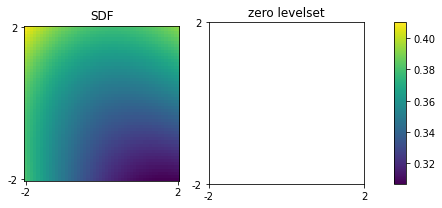

In [25]:
plot2d(lambda x: model(x)[0], ngrid=50)

In [26]:
from typing import Callable, Sequence
from equinox import nn

class NeuralSDF(eqx.Module):
    layers: Sequence[nn.Linear]
    activation: Callable

    def __init__(
        self, 
        in_size: int, 
        width_size: int,
        depth: int,
        *,
        activation: Callable=jax.nn.relu,
        key: jrandom.PRNGKey,
    ):
        keys = jrandom.split(key, depth + 1)
        layers = [nn.Linear(in_size, width_size, key=keys[0])]
        for i in range(depth - 1):
            layers += [nn.Linear(width_size, width_size, key=keys[i+1])]
        layers += [nn.Linear(width_size, 1, key=keys[-1])]
        self.layers = layers
        self.activation = activation

    def __call__(self, x):
        for layer in self.layers[:-1]:
            x = layer(x)
            x = self.activation(x)
        y = self.layers[-1](x)
        return y[0]

In [27]:
model = NeuralSDF(2, 10, 2, key=jrandom.PRNGKey(0))
model(jnp.array([0.1, 0.2]))

DeviceArray(-0.01435012, dtype=float32)

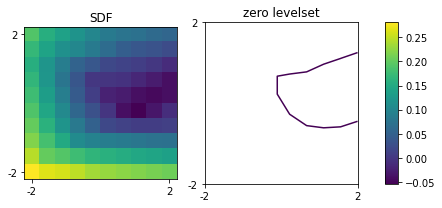

In [28]:
plot2d(lambda x: model(x))

In [29]:
def dataloader(xs, ys, batch_size, *, key):
    dataset_size = xs.shape[0]
    indices = jnp.arange(dataset_size)
    while True:
        perm = jrandom.permutation(key, indices)
        (key,) = jrandom.split(key, 1)
        start = 0
        end = batch_size
        while end < dataset_size:
            batch_perm = perm[start:end]
            yield xs[batch_perm], ys[batch_perm]
            start = end
            end = start + batch_size

In [30]:
xs, ys = discretize2d(sdf_sphere, xy_lims=(-2, 2), ngrid=50)
print(xs.shape)
print(ys.shape)

(50, 50, 2)
(50, 50)


In [31]:
def single_loss_fn(model, x, y):
    return 0.5 * jnp.square(y - model(x))

def batch_loss_fn(model, xs, ys):
    loss_fn = ft.partial(single_loss_fn, model)
    return jnp.mean(vmap(loss_fn)(xs, ys))

@eqx.filter_jit
def make_step(model, xs, ys, opt_state, opt_update):
    loss_fn = eqx.filter_value_and_grad(batch_loss_fn)
    loss, grads = loss_fn(model, xs, ys)
    updates, opt_state = opt_update(grads, opt_state)
    model = eqx.apply_updates(model, updates)
    return loss, model, opt_state

Step=999 Loss=0.009382512420415878


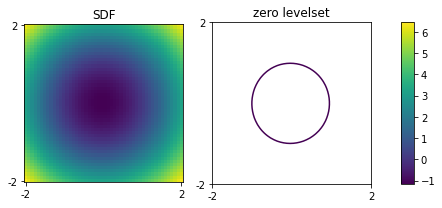

In [34]:
import optax

num_steps = 1000
batch_size = 20
lr = 5e-4
print_every = 50
key = jrandom.PRNGKey(0)

xs, ys = discretize2d(sdf_sphere, xy_lims=(-2, 2), ngrid=50)
xs = xs.reshape(-1, 2)
ys = ys.reshape(-1)
print(xs.shape)
print(ys.shape)

key, model_key, data_key = jrandom.split(key, 3)
model = NeuralSDF(in_size=2, 
                  width_size=50, 
                  depth=3, 
                  activation=jax.nn.softplus,
                  key=model_key)
opt = optax.adam(lr)
opt_state = opt.init(eqx.filter(model, eqx.is_inexact_array))
for i, data in zip(range(num_steps), dataloader(xs, ys, batch_size, key=data_key)):
    xs_batch, ys_batch = data
    loss, model, opt_state = make_step(model, xs_batch, ys_batch, opt_state, opt.update)
    if (i % print_every) == 0 or i == num_steps - 1:
        clear_output(True)
        print(f"Step={i} Loss={loss}")
        plot2d(model, ngrid=50)
        plt.show()